In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import sklearn
from sklearn import datasets

In [3]:
import theano

Using gpu device 0: GeForce GTX 980 Ti (CNMeM is disabled, cuDNN 5105)
/home/topolo/Public/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


I accomplished the above by running this command at the command prompt:   

```    
THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32' jupyter notebook   
```


In [4]:
#import theano
from theano import function, config, sandbox, shared 
import theano.tensor as T
import numpy as np
import time

## More `theano` setup in `jupyter` notebook boilerplate

In [8]:
print( theano.config.device )
print( theano.config.lib.cnmem)  # cf. http://deeplearning.net/software/theano/library/config.html
print( theano.config.print_active_device)# Print active device at when the GPU device is initialized.

gpu
0.0
True


In [44]:
import os, sys
os.getcwd()
os.listdir( os.getcwd() ) 

['LogReg-sklearn.ipynb',
 'LICENSE',
 'theano.pdf',
 'deeplearning.pdf',
 'LaTeXandpdfs',
 'supervised-theano.ipynb',
 'sanity_check_theano_uses_gpu.ipynb',
 '.git',
 'README.md',
 '.ipynb_checkpoints',
 'theano_ML.ipynb',
 'deep-learning--ud730',
 'tf_sanitycheck.ipynb',
 'FedoraNVidiaInstallTips',
 'tf',
 'sampleinputdataX_sklearn.ipynb',
 'Data',
 'simple_logreg.py',
 'MorseTheory.ipynb',
 'tutorial_theano.ipynb',
 'best_model.pkl',
 'gpu_test.py']

In [46]:
%run gpu_test.py THEANO_FLAGS='mode=FAST_RUN,device=gpu,floatX=float32,lib.cnmem=0.85' # note lib.cnmem option for CnMem

[GpuElemwise{exp,no_inplace}(<CudaNdarrayType(float32, vector)>), HostFromGpu(GpuElemwise{exp,no_inplace}.0)]
Looping 1000 times took 0.413888 seconds
Result is [ 1.23178029  1.61879349  1.52278066 ...,  2.20771813  2.29967761
  1.62323296]
Used the gpu


# sample data boilerplate

In [9]:
# Load the diabetes dataset
diabetes = sklearn.datasets.load_diabetes()

In [10]:
diabetes_X = diabetes.data
diabetes_Y = diabetes.target

In [11]:
#diabetes_X1 = diabetes_X[:,np.newaxis,2]
diabetes_X1 = diabetes_X[:,np.newaxis, 2].astype(theano.config.floatX)
#diabetes_Y  = diabetes_Y.reshape( diabetes_Y.shape[0], 1)
diabetes_Y = diabetes_Y.astype(theano.config.floatX)

## Linear regression

cf. [Linear Regression In Theano](https://roshansanthosh.wordpress.com/2015/02/22/linear-regression-in-theano/)

[`1_linear_regression.py` from `github` Newmu/Theano-Tutorials](https://github.com/Newmu/Theano-Tutorials/blob/master/1_linear_regression.py)

Train on $m$ number of input data points

In [12]:
m_lin = diabetes_X1.shape[0]

### input, output variables $x$, $y$ for Theano

In [28]:
#x1 = T.vector('x1')  # X1, input data, with only 1 feature, i.e. X \in \mathbb{R}^N, d=1 
#ylin = T.vector('ylin') # target variable for linear regression, so that Y \in \mathbb{R}

x1 = T.scalar('x1')  # X1, input data, with only 1 feature, i.e. X \in \mathbb{R}^N, d=1 
ylin = T.scalar('ylin') # target variable for linear regression, so that Y \in \mathbb{R}

### Parameters (for a linear slope)  

$$    
(\theta^0, \theta^1) \in \mathbb{R}^2   
$$

In [29]:
thet0_init_val = np.random.randn()
thet1_init_val = np.random.randn()

In [30]:
thet0 = theano.shared( value=thet0_init_val, name='thet0', borrow=True)  # \theta^0
thet1 = theano.shared( thet1_init_val, name='thet1', borrow=True)   # \theta^1


### hypothesis function $h_{\theta}$

$$   
h_{\theta}(x) = \theta_1 x + \theta_0
$$

In [31]:
#h_thet = T.dot( thet1, x1) + thet0
# whereas, Newmu uses
h_thet = thet1 * x1 + thet0

### Cost function $J(\theta)$

In [32]:
# roshansanthosh uses 
#Jthet = T.sum( T.pow(h_thet-ylin,2))/(2*m_lin)

# whereas, Newmu uses
# Jthet = T.mean( T.sqr( thet_1*x1 + thet_0 - ylin ))

Jthet = T.mean( T.pow( h_thet-ylin,2))/2
#Jthet = sandbox.cuda.basic_ops.gpu_from_host( T.mean( 
#        sandbox.cuda.basic_ops.gpu_from_host( T.pow( h_thet-ylin,2))))/2

$$
\text{grad}_{\theta}J(\theta) = ( \text{grad}_{\theta^0} J , \text{grad}_{\theta^1} J )   
$$

In [33]:
grad_thet0 = T.grad(Jthet, thet0)
grad_thet1 = T.grad(Jthet, thet1)


In [19]:
# so-called "learning rate"
gamma = 0.01

Note that "**updates** (iterable over pairs (shared_variable, new_expression) List, tuple or dict.) – expressions for new SharedVariable values" cf. [Theano doc](http://deeplearning.net/software/theano/library/compile/function.html)

In [34]:
train_lin = theano.function(inputs = [x1,ylin], outputs=Jthet, 
                        updates=[[thet1,thet1-gamma*grad_thet1],[thet0,thet0-gamma*grad_thet0]])



In [35]:
test_lin = theano.function([x1],h_thet)

In [100]:
#X1_lin_in = shared( diabetes_X1 ,'float32')
#Y_lin_out = shared( diabetes_Y, 'float32')

In [23]:
training_steps = 1000 # 10000

In [36]:
sh_diabetes_X1 = shared( diabetes_X1 , borrow=True)
sh_diabetes_Y  = shared( diabetes_Y, borrow=True)

In [37]:
"""
for i in range(training_steps):
    for x,y in zip( diabetes_X1, diabetes_Y):
        Jthet_val = train_lin( x, y )
        """

for i in range(training_steps):
#    for x,y in zip( sh_diabetes_X1, sh_diabetes_Y) :
#        Jthet_val = train_lin( x,y)
    Jthet_val = train_lin( sh_diabetes_X1, sh_diabetes_Y)

TypeError: ('Bad input argument to theano function with name "<ipython-input-34-92f3da11396a>:2"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

In [27]:
print(Jthet_val)

NameError: name 'Jthet_val' is not defined

In [129]:
print( thet0.get_value() ); print( thet1.get_value() )



151.746080721
942.701275851


In [134]:
test_lin_out = np.array( [ test_lin( x ) for x in diabetes_X1 ] ) 

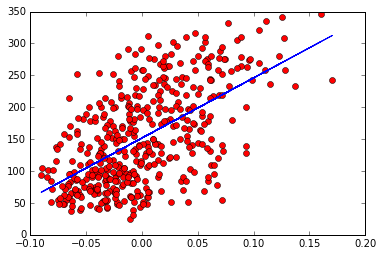

In [137]:
plt.plot(diabetes_X1,diabetes_Y,'ro')
plt.plot(diabetes_X1,test_lin_out)

In [38]:
if any([x.op.__class__.__name__ in ['GpuGemm','GpuGemv'] for x in train_lin.maker.fgraph.toposort()]):
    print("Used the gpu")
else:
    print(train_lin.maker.fgraph.toposort())

[Elemwise{Composite{(((i0 * i1) + i2) - i3)}}(thet1, x1, thet0, ylin), Elemwise{Composite{(i0 - (i1 * i2))}}[(0, 0)](thet0, TensorConstant{0.00999999977648}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0), Elemwise{Composite{(i0 - (i1 * i2 * i3))}}[(0, 0)](thet1, TensorConstant{0.00999999977648}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0, x1), Elemwise{Composite{(i0 * sqr(i1))}}[(0, 1)](TensorConstant{0.5}, Elemwise{Composite{(((i0 * i1) + i2) - i3)}}.0)]


In [39]:
if np.any([isinstance(x.op,T.Elemwise) for x in train_lin.maker.fgraph.toposort()]):
    print("Used the cpu")

Used the cpu


## Linear Algebra and `theano`

cf. [Week 1, Linear Algebra Review, Coursera, Machine Learning with Ng](https://www.coursera.org/learn/machine-learning/lecture/38jIT/matrices-and-vectors)

I'll take this opportunity to provide a dictionary between the syntax of linear algebra math and `numpy`.   

Essentially, what I did was take Coursera's [Week 1, Linear Algebra Review](https://www.coursera.org/learn/machine-learning/lecture/dpF1j/matrix-matrix-multiplication) and then translated the math into **`theano`**, and in particular, running theano on the **GPU**.


#### Matrix addition

cf. [Coursera, Intro. to Machine Learning, Linear Algebra Review, Addition and Scalar Multiplication](https://www.coursera.org/learn/machine-learning/lecture/R4hiJ/addition-and-scalar-multiplication)

In [69]:
A = T.matrix('A')
B = T.matrix('B')
#matadd = function([A,B], A+B)
#matadd = function([A,B],sandbox.cuda.basic_ops.gpu_from_host(A+B) )
# Note: we are just defining the expressions, nothing is evaluated here!  
C = sandbox.cuda.basic_ops.gpu_from_host(A+B)
matadd = function([A,B], C)

In [121]:
#A = T.dmatrix('A')
#B = T.dmatrix('B')

A = T.matrix('A')
B = T.matrix('B')

C_out = A + B
matadd_CPU = function([A,B], C_out)

In [73]:
A_eg = shared( np.array([[8,6,9],[10,1,10]]), 'float32')
B_eg = shared( np.array([[3,10,2],[6,1,-1]]), 'float32')


In [85]:
A_eg_CPU = np.array([[8,6,9],[10,1,10]])
B_eg_CPU = np.array([[3,10,2],[6,1,-1]])

In [96]:
print(A_eg_CPU)
print( type( A_eg_CPU ))
print( A_eg_CPU.shape)
print( B_eg_CPU.shape)

[[ 8  6  9]
 [10  1 10]]
<type 'numpy.ndarray'>
(2, 3)
(2, 3)


In [70]:
print( matadd.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]


In [122]:
print( matadd_CPU.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0), HostFromGpu(GpuElemwise{Add}[(0, 0)].0)]


In [71]:
matadd( A_eg, B_eg)

TypeError: ('Bad input argument to theano function with name "<ipython-input-69-40293d053d65>:7"  at index 0(0-based)', 'Expected an array-like object, but found a Variable: maybe you are trying to call a function on a (possibly shared) variable instead of a numeric array?')

The way to do it, to "force" on the GPU, is like this (cf. [Speeding up your Neural Network with Theano and the GPU - Wild ML](http://www.wildml.com/2015/09/speeding-up-your-neural-network-with-theano-and-the-gpu/)):

In [76]:
np.random.randn( *A_eg_CPU.shape )

array([[ 1.01645633,  0.49394088, -0.22904526],
       [-0.44323914, -0.27948502,  0.335645  ]])

In [78]:
C_out = theano.shared( np.random.randn( *A_eg_CPU.shape).astype('float32') )

In [80]:
C_out.type()

<CudaNdarrayType(float32, matrix)>

In [110]:
#A_in = shared( A_eg_CPU, "float32")
#A_in = shared( A_eg_CPU, "float32")

A_in = shared( A_eg_CPU.astype("float32"), "float32")
B_in = shared( B_eg_CPU.astype("float32"), "float32")
#C_out_GPU = A_in + B_in
C_out_GPU = sandbox.cuda.basic_ops.gpu_from_host(A_in+B_in)


In [111]:
matadd_GPU = theano.function( [], C_out_GPU)

In [112]:
C_out_GPU_result = matadd_GPU()

In [113]:
C_out_GPU_result

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

Notice how **DIFFERENT** this setup or syntax is: we have to set up tensor or matrix *shared variables* `A_n`, `B_in`, which are then used to define the theano function, `theano.function`.  "By using shared variables we ensure that they are present in the GPU memory".  cf. [Linear Algebra Shootout: NumPy vs. Theano vs. TensorFlow](https://simplyml.com/linear-algebra-shootout-numpy-vs-theano-vs-tensorflow-2/)

In [114]:
print( matadd_GPU.maker.fgraph.toposort() )

[GpuElemwise{add,no_inplace}(float32, float32)]


In [128]:
#if np.any([isinstance(C_out_GPU.op, tensor.Elemwise ) and 
if np.any([isinstance( C_out_GPU.op, T.Elemwise ) and 
           ('Gpu' not in type( C_out_GPU.op).__name__) for x in matadd_GPU.maker.fgraph.toposort()]) :
    print('Used the cpu')
else:
    print('Used the gpu')

AttributeError: 'CudaNdarrayVariable' object has no attribute 'op'

In [124]:
matadd_CPU( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") )

array([[ 11.,  16.,  11.],
       [ 16.,   2.,   9.]], dtype=float32)

In [55]:
type(A_eg)

theano.tensor.sharedvar.TensorSharedVariable

In [59]:
print( type( numpy.asarray(rng.rand(2000)) ) )
numpy.asarray(rng.rand(2000)).shape

<type 'numpy.ndarray'>


(2000,)

**Bottom Line:** there are **2** ways of doing linear algebra *on the GPU*

1. symbolic computation with the usual arguments    

$$
A + B = C \in \text{Mat}_{\mathbb{R}}(M,N)   
$$   

$ \forall \, A, B \in \text{Mat}_{\mathbb{R}}(M,N)$

In [132]:
A = T.matrix('A')
B = T.matrix('B')

C = sandbox.cuda.basic_ops.gpu_from_host( A + B ) # vs. 
# C = A + B  # this will result in an output array on the host, as opposed to CudaNdarray on device
matadd = function([A,B], C)

In [133]:
print( matadd.maker.fgraph.toposort() )

[GpuFromHost(B), GpuFromHost(A), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]


In [134]:
matadd( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") )

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

2. with *shared variables*

In [140]:
A_in = shared( A_eg_CPU.astype("float32"), "float32")  # initialize with the input values, A_eg_CPU, anyway
B_in = shared( B_eg_CPU.astype("float32"), "float32")  # initialize with the input values B_eg_CPU, anyway

# C_out = A_in + B_in # this version will output to the host as a numpy.ndarray
# indeed, reading the graph,
"""
[GpuElemwise{add,no_inplace}(float32, float32), HostFromGpu(GpuElemwise{add,no_inplace}.0)]
"""
# this version immediately below, in 1 line, will result in a CudaNdarray on device
C_out = sandbox.cuda.basic_ops.gpu_from_host(A_in+B_in)

matadd_GPU = theano.function( [], C_out)

In [141]:
print( matadd_GPU.maker.fgraph.toposort() )

[GpuElemwise{add,no_inplace}(float32, float32)]


In [142]:
C_out_result = matadd_GPU()

In [143]:
C_out_result

CudaNdarray([[ 11.  16.  11.]
 [ 16.   2.   9.]])

### Scalar Multiplication (on the GPU)

cf. [Scalar Multiplication of Linear Algebra Review, coursera, Machine Learning Intro by Ng](https://www.coursera.org/learn/machine-learning/lecture/R4hiJ/addition-and-scalar-multiplication)

In [149]:
A_2 = np.array( [[4,5],[1,7] ])

In [145]:
a = T.scalar('a')

F = sandbox.cuda.basic_ops.gpu_from_host( a*A )
scalarmul = theano.function([a,A],F)

In [146]:
print( scalarmul.maker.fgraph.toposort() )

[GpuFromHost(A), GpuFromHost(a), GpuDimShuffle{x,x}(GpuFromHost.0), GpuElemwise{Mul}[(0, 1)](GpuDimShuffle{x,x}.0, GpuFromHost.0)]


In [150]:
scalarmul( np.float32( 2.), A_2.astype("float32"))

CudaNdarray([[  8.  10.]
 [  2.  14.]])

# Composition; Confirming that you can do composition of scalar multiplication on a matrix (or ring) addition

Being able to do composition is *very important* in math

In [152]:
scalarmul( np.float32(2.), matadd( A_eg_CPU.astype("float32"), B_eg_CPU.astype("float32") ) )

CudaNdarray([[ 22.  32.  22.]
 [ 32.   4.  18.]])

In [156]:
u = T.vector('u')
v = T.vector('v')

w = sandbox.cuda.basic_ops.gpu_from_host( u + v)
vecadd = theano.function( [u,v],w)

t = sandbox.cuda.basic_ops.gpu_from_host( a * u)
scalarmul_vec = theano.function([a,u], t)


In [157]:
print(vecadd.maker.fgraph.toposort())  
print(scalarmul_vec.maker.fgraph.toposort())  


[GpuFromHost(v), GpuFromHost(u), GpuElemwise{Add}[(0, 0)](GpuFromHost.0, GpuFromHost.0)]
[GpuFromHost(u), GpuFromHost(a), GpuDimShuffle{x}(GpuFromHost.0), GpuElemwise{Mul}[(0, 1)](GpuDimShuffle{x}.0, GpuFromHost.0)]


In [162]:
u_eg = np.array( [4,6,7], dtype="float32")
v_eg = np.array( [2,1,0], dtype="float32")

print( u_eg.shape)

(3,)


In [161]:
scalarmul_vec( np.float32(0.5), u_eg )

CudaNdarray([ 2.   3.   3.5])

In [163]:
vecadd( scalarmul_vec( np.float32(0.5), u_eg ) , scalarmul_vec( np.float32(-3.), v_eg )  )

CudaNdarray([-4.   0.   3.5])

This was the computer equivalent to mathematical expression:  

$$   
\left[ \begin{matrix} 4 \\ 6 \\ 7 \end{matrix} \right] /2 - 3 * \left[ \begin{matrix} 2 \\ 1 \\ 0 \end{matrix} \right]
$$   


### sAxy or A-V multiplication or so-called "Gemv", or Matrix Multiplication on a vector, or linear transformation on a R-module, or vector space   

i.e.   

$$
Av = B   
$$

In [164]:
B_out = sandbox.cuda.basic_ops.gpu_from_host( T.dot(A,v))
AVmul = theano.function([A,v], B_out)
print(AVmul.maker.fgraph.toposort())

[GpuFromHost(v), GpuFromHost(A), Shape_i{0}(A), GpuAllocEmpty(Shape_i{0}.0), GpuGemv{inplace}(GpuAllocEmpty.0, TensorConstant{1.0}, GpuFromHost.0, GpuFromHost.0, TensorConstant{0.0})]


In [165]:
AVmul( np.array([[1,0,3],[2,1,5],[3,1,2]]).astype("float32"), np.array([1,6,2]).astype("float32"))

CudaNdarray([  7.  18.  13.])

In [168]:
AVmul( np.array([[1,0,0],[0,1,0],[0,0,1]]).astype("float32"), np.array([1,6,2]).astype("float32"))

CudaNdarray([ 1.  6.  2.])

### AB or Gemm or Matrix Multiplication, i.e. Ring multiplication   

i.e.   
$$  
A*B = C  
$$

In [166]:
C_f = sandbox.cuda.basic_ops.gpu_from_host( T.dot(A,B)) 
matmul = theano.function([A,B], C_f)
print( matmul.maker.fgraph.toposort())

[GpuFromHost(B), GpuFromHost(A), GpuDot22(GpuFromHost.0, GpuFromHost.0)]


In [167]:
matmul( np.array( [[1,3],[2,4],[0,5]]  ).astype("float32"), np.array([[1,0],[2,3]]).astype("float32")  )

CudaNdarray([[  7.   9.]
 [ 10.  12.]
 [ 10.  15.]])

### Inverse and Transpose   

cf. [Inverse and Transpose](https://www.coursera.org/learn/machine-learning/lecture/FuSWY/inverse-and-transpose)

In [170]:
Ainverse = sandbox.cuda.basic_ops.gpu_from_host( T.inv(A))
Ainv = theano.function([A], Ainverse)
print(Ainv.maker.fgraph.toposort())

[GpuFromHost(A), GpuElemwise{Inv}[(0, 0)](GpuFromHost.0)]


In [172]:
Atranspose = sandbox.cuda.basic_ops.gpu_from_host( A.T)
AT = theano.function([A],Atranspose)
print(AT.maker.fgraph.toposort())

[GpuFromHost(A), GpuDimShuffle{1,0}(GpuFromHost.0)]
